In [2]:
import os
import numpy as np
import pandas as pd
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchvision import models

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# configurations

DATA_DIR = "./data/UrbanSound8K"
MODEL_DIR = "./model/model-e"

SAMPLE_RATE = 22050
CLIP_DURATION = 4.0
N_MELS = 128
FMIN = 0
FMAX = SAMPLE_RATE // 2
N_CLASSES = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Class names for UrbanSound8K (classID 0-9)
CLASS_NAMES = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

Using device: cpu


In [4]:
# Test dataset (no augmentation, one fold)

class UrbanSound8KWaveTestDataset(Dataset):
    def __init__(
        self,
        data_dir: str,
        fold: int,
        sample_rate: int = SAMPLE_RATE,
        duration: float = CLIP_DURATION,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.fold = fold
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_samples = int(sample_rate * duration)

        meta_path = os.path.join(data_dir, "metadata", "UrbanSound8K.csv")
        df = pd.read_csv(meta_path)
        self.df = df[df["fold"] == fold].reset_index(drop=True)
        self.labels = self.df["classID"].astype(int).to_numpy()

    def __len__(self):
        return len(self.df)

    def _load_waveform(self, index: int) -> torch.Tensor:
        row = self.df.iloc[index]
        fold = row["fold"]
        fname = row["slice_file_name"]
        path = os.path.join(self.data_dir, "audio", f"fold{fold}", fname)

        # resample
        wav, sr = librosa.load(path, sr=self.sample_rate, mono=True)

        # pad / truncate to 4 seconds
        if len(wav) < self.n_samples:
            wav = np.pad(wav, (0, self.n_samples - len(wav)), mode="constant")
        elif len(wav) > self.n_samples:
            wav = wav[: self.n_samples]

        # normalization
        if np.std(wav) > 1e-6:
            wav = (wav - wav.mean()) / wav.std()

        wav = wav.astype(np.float32)
        return torch.from_numpy(wav).unsqueeze(0)  # [1, T]

    def __getitem__(self, index: int):
        x = self._load_waveform(index)
        y = int(self.labels[index])
        return x, torch.tensor(y, dtype=torch.long)

In [5]:
# mel transformation (change waveform to mel spectrogram)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=N_MELS,
    f_min=FMIN,
    f_max=FMAX,
    power=2.0,
).to(DEVICE)

db_transform = torchaudio.transforms.AmplitudeToDB().to(DEVICE)


def waveform_batch_to_mel_3ch(x_wave: torch.Tensor) -> torch.Tensor:
    x_in = x_wave.squeeze(1)  # [B, T]

    # generate mel
    mel = mel_transform(x_in)
    mel_db = db_transform(mel)

    # normalization
    mean = mel_db.mean(dim=(1, 2), keepdim=True)
    std = mel_db.std(dim=(1, 2), keepdim=True)
    mel_db = (mel_db - mean) / (std + 1e-6)

    # add dimension for channel [B, 1, n_mels, frames]
    mel_db = mel_db.unsqueeze(1)

    # copy to 3 channels [B, 3, n_mels, frames]
    mel_db = mel_db.repeat(1, 3, 1, 1)

    return mel_db

In [6]:
# pretrained VGG-13-BN model (pretrained on imagenet1k)

def create_pretrained_vgg13_b(num_classes: int = N_CLASSES) -> nn.Module:
    try:
        vgg = models.vgg13_bn(weights=models.VGG13_BN_Weights.IMAGENET1K_V1)
    except AttributeError:
        vgg = models.vgg13_bn(pretrained=True)

    in_features = vgg.classifier[-1].in_features
    vgg.classifier[-1] = nn.Linear(in_features, num_classes)
    return vgg

In [7]:
# Confusion matrix plot function

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"): # Plot  confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


Evaluating fold 1
Loading model from: ./model/model-e/vgg13_e_fold1.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 1] Test accuracy: 0.6082

Evaluating fold 2
Loading model from: ./model/model-e/vgg13_e_fold2.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 2] Test accuracy: 0.6599

Evaluating fold 3
Loading model from: ./model/model-e/vgg13_e_fold3.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 3] Test accuracy: 0.5968

Evaluating fold 4
Loading model from: ./model/model-e/vgg13_e_fold4.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 4] Test accuracy: 0.6172

Evaluating fold 5
Loading model from: ./model/model-e/vgg13_e_fold5.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 5] Test accuracy: 0.6506

Evaluating fold 6
Loading model from: ./model/model-e/vgg13_e_fold6.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 6] Test accuracy: 0.5917

Evaluating fold 7
Loading model from: ./model/model-e/vgg13_e_fold7.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 7] Test accuracy: 0.6026

Evaluating fold 8
Loading model from: ./model/model-e/vgg13_e_fold8.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 8] Test accuracy: 0.5943

Evaluating fold 9
Loading model from: ./model/model-e/vgg13_e_fold9.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 9] Test accuracy: 0.6556

Evaluating fold 10
Loading model from: ./model/model-e/vgg13_e_fold10.pth


/opt/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Fold 10] Test accuracy: 0.6703


Cross-validation overall metrics (10 folds combined) (Model E)
Overall test accuracy (all folds combined): 0.6248

Per-class precision, recall, F1, and support:
 0 (air_conditioner  )  Precision: 0.5292  Recall: 0.4620  F1: 0.4933  Support: 1000
 1 (car_horn         )  Precision: 0.4513  Recall: 0.3776  F1: 0.4112  Support: 429
 2 (children_playing )  Precision: 0.6110  Recall: 0.7980  F1: 0.6921  Support: 1000
 3 (dog_bark         )  Precision: 0.6105  Recall: 0.6740  F1: 0.6407  Support: 1000
 4 (drilling         )  Precision: 0.7129  Recall: 0.5960  F1: 0.6492  Support: 1000
 5 (engine_idling    )  Precision: 0.5967  Recall: 0.5800  F1: 0.5882  Support: 1000
 6 (gun_shot         )  Precision: 0.9182  Recall: 0.5401  F1: 0.6801  Support: 374
 7 (jackhammer       )  Precision: 0.5093  Recall: 0.6860  F1: 0.5846  Support: 1000
 8 (siren            )  Precision: 0.7331  Recall: 0.7126  F1: 0.7227  Support: 929
 9 (street_music     )  Precision: 0.7808  

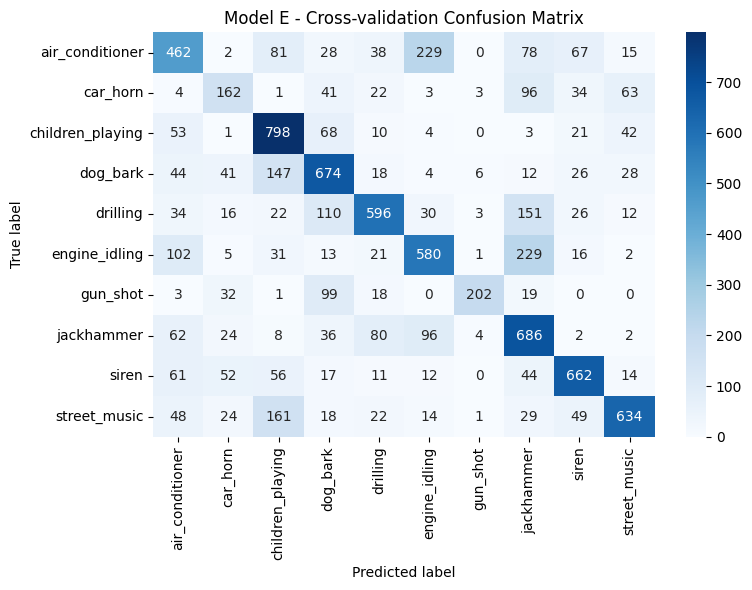


Fold-wise test accuracies:
Fold 1: 0.6082
Fold 2: 0.6599
Fold 3: 0.5968
Fold 4: 0.6172
Fold 5: 0.6506
Fold 6: 0.5917
Fold 7: 0.6026
Fold 8: 0.5943
Fold 9: 0.6556
Fold 10: 0.6703


In [8]:
# Evaluate all 10 folds, predictions in total

all_y_true = []
all_y_pred = []
fold_accuracies = {}

for fold in range(1, 11):
    model_path = os.path.join(MODEL_DIR, f"vgg13_e_fold{fold}.pth")
    if not os.path.exists(model_path):
        print(f"[Fold {fold}] WARNING: model file not found: {model_path}")
        continue

    print(f"\nEvaluating fold {fold}")
    print(f"Loading model from: {model_path}")

    # Build test dataset and loader
    test_dataset = UrbanSound8KWaveTestDataset(DATA_DIR, fold=fold)
    test_loader = DataLoader(
        test_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    # Create model and load weights
    model = create_pretrained_vgg13_b(num_classes=N_CLASSES).to(DEVICE)
    state_dict = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()

    fold_y_true = []
    fold_y_pred = []

    with torch.no_grad():
        for x_wave, y in test_loader:
            x_wave = x_wave.to(DEVICE)
            y = y.to(DEVICE)

            x = waveform_batch_to_mel_3ch(x_wave)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            fold_y_true.extend(y.cpu().numpy().tolist())
            fold_y_pred.extend(preds.cpu().numpy().tolist())

    fold_y_true = np.array(fold_y_true)
    fold_y_pred = np.array(fold_y_pred)

    acc = accuracy_score(fold_y_true, fold_y_pred)
    fold_accuracies[fold] = acc
    print(f"[Fold {fold}] Test accuracy: {acc:.4f}")

    # Append to total lists for cross-validation metrics
    all_y_true.extend(fold_y_true.tolist())
    all_y_pred.extend(fold_y_pred.tolist())


# Compute overall metrics across all test folds
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

print("\n")
print("=" * 80)
print("Cross-validation overall metrics (10 folds combined) (Model E)")

# overall accuracy (across all test folds)
overall_acc = accuracy_score(all_y_true, all_y_pred)
print(f"Overall test accuracy (all folds combined): {overall_acc:.4f}\n")

# per-class precision, recall, F1 (per class)
prec, rec, f1, support = precision_recall_fscore_support(
    all_y_true, all_y_pred, labels=range(N_CLASSES)
)

print("Per-class precision, recall, F1, and support:")
for i, cls in enumerate(CLASS_NAMES):
    print(
        f"{i:2d} ({cls:17s})  "
        f"Precision: {prec[i]:.4f}  "
        f"Recall: {rec[i]:.4f}  "
        f"F1: {f1[i]:.4f}  "
        f"Support: {support[i]}"
    )

# print("\nDetailed classification report:")
# print(
#     classification_report(
#         all_y_true,
#         all_y_pred,
#         labels=range(N_CLASSES),
#         target_names=CLASS_NAMES,
#         digits=4,
#     )
# )

# confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred, labels=range(N_CLASSES))
# print("\nConfusion matrix (rows = true, cols = predicted):")
# print(cm)

plot_confusion_matrix(
    cm,
    CLASS_NAMES,
    title="Model E - Cross-validation Confusion Matrix",
)

# print fold-wise accuracies for reference
print("\nFold-wise test accuracies:")
for fold in sorted(fold_accuracies.keys()):
    print(f"Fold {fold}: {fold_accuracies[fold]:.4f}")